## Прогнозирование продаж по расходам на рекламу с использованием линейной регрессии

In [1]:
import numpy as np, pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

Данные

In [2]:
ad = pd.read_csv("../../data/ad.csv")
ad.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


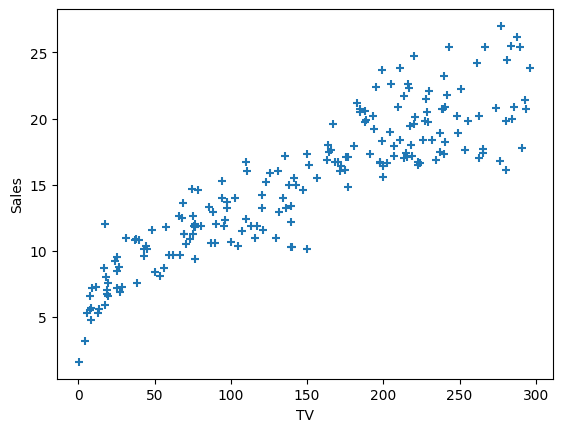

In [3]:
plt.scatter(ad.TV, ad.Sales, marker="+")
plt.xlabel("TV")
plt.ylabel("Sales")
plt.show()

Обучение модели

In [4]:
lr = LinearRegression()

In [5]:
lr.fit(ad[['TV']], ad[['Sales']])

LinearRegression()

Предсказания

In [6]:
sales_pred = lr.predict(ad[['TV']])

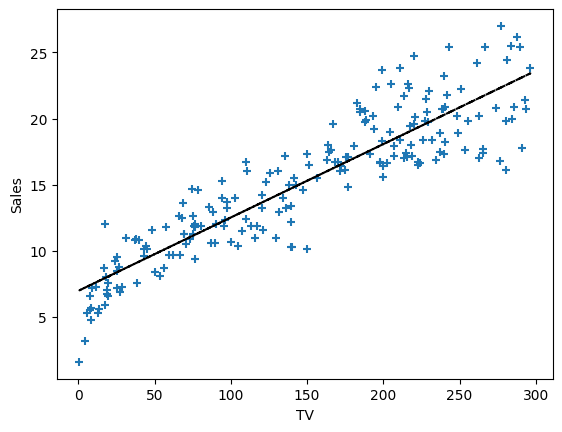

In [7]:
plt.plot(ad.TV, sales_pred,"k--")
plt.scatter(ad.TV, ad.Sales, marker='+')
plt.xlabel("TV")
plt.ylabel('Sales')
plt.show()

## Прогнозирования доходов от клиентов

Данные

In [8]:
df = pd.read_csv("../../data/retail_transactions.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2020-03-16 11:36:00,1.25,18231.0,United Kingdom
1,559898,21868,POTTING SHED TEA MUG,6,2020-07-13 12:18:00,1.25,16225.0,United Kingdom
2,548648,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2020-04-01 13:20:00,0.85,12949.0,United Kingdom
3,540543,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,4,2020-01-09 15:23:00,2.95,14395.0,United Kingdom
4,561390,20726,LUNCH BAG WOODLAND,10,2020-07-27 09:52:00,1.65,17068.0,United Kingdom


Преобразовать InvoiceDate в DateTime тип

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  int64  
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 24.3+ MB


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Общее кол-во дохода за транзакцию

In [11]:
df['revenue'] = df['UnitPrice']*df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2020-03-16 11:36:00,1.25,18231.0,United Kingdom,15.0
1,559898,21868,POTTING SHED TEA MUG,6,2020-07-13 12:18:00,1.25,16225.0,United Kingdom,7.5
2,548648,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2020-04-01 13:20:00,0.85,12949.0,United Kingdom,20.4
3,540543,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,4,2020-01-09 15:23:00,2.95,14395.0,United Kingdom,11.8
4,561390,20726,LUNCH BAG WOODLAND,10,2020-07-27 09:52:00,1.65,17068.0,United Kingdom,16.5


Сводка

In [12]:
operations = {'revenue':'sum',
              'InvoiceDate':'first',
              'CustomerID':'first',
              }
df = df.groupby('InvoiceNo').agg(operations)

In [13]:
df.head()

,revenue,InvoiceDate,CustomerID
InvoiceNo,,,
536365,139.12,2019-12-01 08:26:00,17850.0
536366,22.20,2019-12-01 08:28:00,17850.0
536367,278.73,2019-12-01 08:34:00,13047.0
536368,70.05,2019-12-01 08:34:00,13047.0
536369,17.85,2019-12-01 08:35:00,13047.0


Год в отдельный столбец

In [14]:
df['year'] = df['InvoiceDate'].dt.year

Раздница дней между 31.02.2019 и датой выставления счета

In [15]:
df['days_since'] = (dt.datetime(year=2019, month=12, day=31) - df['InvoiceDate']).apply(
    lambda x: x.days)

Сводные данные

In [16]:
operations = {'revenue':'sum',
              'days_since':['max','min','nunique']}

X = df[df['year'] == 2019].groupby('CustomerID').agg(operations)

X.head()

revenue days_since            
                sum        max min nunique
CustomerID                                
12347.0      711.79         23  23       1
12348.0      892.80         14  14       1
12370.0     1868.02         16  13       2
12377.0     1001.52         10  10       1
12383.0      600.72          8   8       1

Преобразуем мультииндекс

In [17]:
X.columns = [' '.join(col).strip() for col in X.columns.values]

In [18]:
X.head()

,revenue sum,days_since max,days_since min,days_since nunique
CustomerID,,,,
12347.0,711.79,23,23,1
12348.0,892.80,14,14,1
12370.0,1868.02,16,13,2
12377.0,1001.52,10,10,1
12383.0,600.72,8,8,1


Средний расход на заказ

In [19]:
X['avg_order_cost'] = X['revenue sum'] / X['days_since nunique']

Сумма за 2020 год, которую нужно будет предсказать

In [20]:
y = df[df['year'] == 2020].groupby('CustomerID')['revenue'].sum()

Свести все в одну таблицу

In [21]:
wrangled_df = pd.concat([X,y], axis=1)
wrangled_df.columns = ['revenue_2019',
                       'days_since_first_purchase',
                       'days_since_last_purchase',
                       'number_of_purchases',
                       'avg_order_cost',
                       'revenue_2020',
                       ]

wrangled_df.head()

,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
CustomerID,,,,,,
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12370.0,1868.02,16.0,13.0,2.0,934.01,1677.67
12377.0,1001.52,10.0,10.0,1.0,1001.52,626.60
12383.0,600.72,8.0,8.0,1.0,600.72,1249.84


Отбросить клиентов, которые не проявляли активность в 2019 и 2020 годах

In [22]:
wrangled_df = wrangled_df[~wrangled_df.revenue_2019.isnull()]
wrangled_df = wrangled_df[~wrangled_df.revenue_2020.isnull()]

Отсеять выбросы

In [23]:
wrangled_df = wrangled_df[wrangled_df.revenue_2020
                          < ((wrangled_df.revenue_2020.median())
                             + wrangled_df.revenue_2020.std()*3)]

wrangled_df = wrangled_df[wrangled_df.revenue_2019
                          < ((wrangled_df.revenue_2019.median())
                             + wrangled_df.revenue_2019.std()*3)]


Сохраним в файл

In [24]:
wrangled_df.to_csv('../../data/wrangled_transactions.csv')
wrangled_df.head()

,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
CustomerID,,,,,,
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12370.0,1868.02,16.0,13.0,2.0,934.01,1677.67
12377.0,1001.52,10.0,10.0,1.0,1001.52,626.60
12383.0,600.72,8.0,8.0,1.0,600.72,1249.84


Парная диаграмма

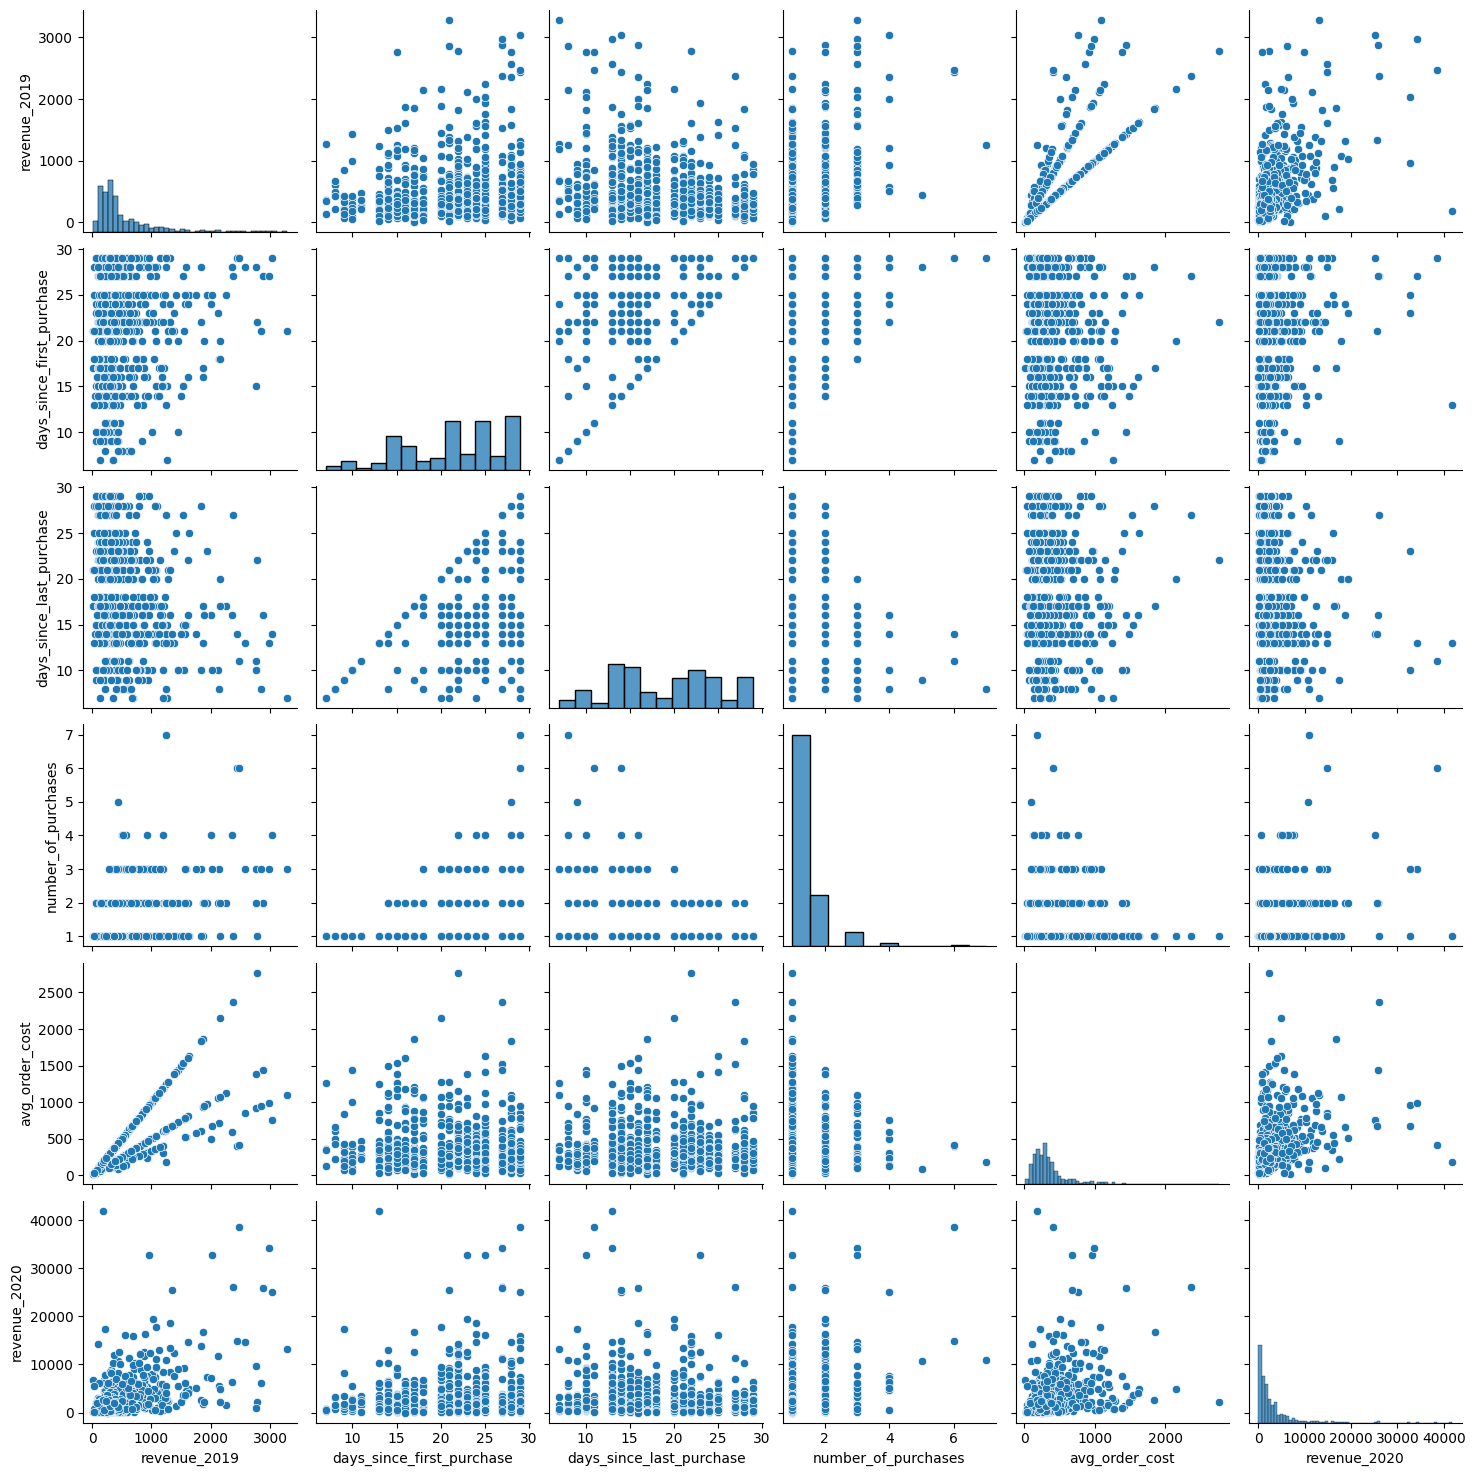

In [25]:
sns.pairplot(wrangled_df)
plt.show()

Парная диаграмма только для дохода за 2020

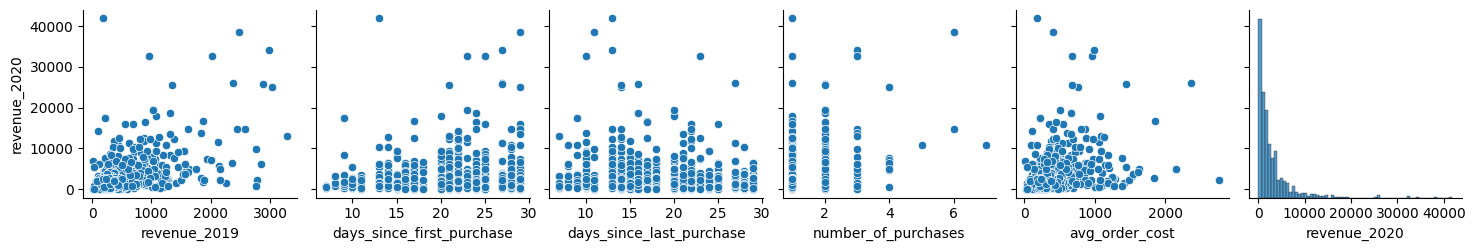

In [27]:
sns.pairplot(wrangled_df, x_vars=wrangled_df.columns, y_vars='revenue_2020')
plt.show()

Таб корреляции

In [28]:
wrangled_df.corr()

,revenue_2019,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,revenue_2020
revenue_2019,1.000000,0.109692,-0.254964,0.504438,0.779401,0.548234
days_since_first_purchase,0.109692,1.000000,0.641574,0.327502,-0.074321,0.061743
days_since_last_purchase,-0.254964,0.641574,1.000000,-0.398268,-0.054051,-0.171294
number_of_purchases,0.504438,0.327502,-0.398268,1.000000,-0.012466,0.355751
avg_order_cost,0.779401,-0.074321,-0.054051,-0.012466,1.000000,0.357384
revenue_2020,0.548234,0.061743,-0.171294,0.355751,0.357384,1.000000
